# EOS Solver for TOV w/ DM

In [1]:
import numpy as np
from scipy import constants as c
import matplotlib.pyplot as plt 
from scipy import optimize
from scipy import integrate
from scipy import interpolate

#---

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
rcParams['font.family'] = 'default' 
rcParams['font.size'] = 15
rcParams['font.weight'] = 300

In [2]:
# conversion from SI to NU

gev =  c.e * 1e9
nu_length = c.hbar * c.c /gev
nu_eps = gev / (nu_length**3)     # 1 GeV^4 = 1 nu_eps (2e37 Jm-3)
nu_mass = c.c**-2 * gev           # 1 GeV   = 1 nu_mass (1.8e-27 kg)
nu_time = c.hbar/gev              # 1 GeV-1 = 1 nu_time (6.58e-25 s)
nu_G = c.G / (nu_length**3 / (nu_mass * nu_time**2)) 

## (1) Baryonic EOS: 

### $$p_1=\frac{1}{3}(\epsilon_1-4B)$$

In [ ]:
B = 0.145

eps_b = lambda p: 3*p + 4*(B**4)

In [ ]:
## TOV - test for single component baryon:

def test_baryon(r, v):
    m, p = v
    e = eps_b(p)
    return [4*c.pi* r**2 * e, (-nu_G*m*e)/(r**2) * \
                 (1+(p/e)) * (1+((4*c.pi * r**3 * p)/(m))) / (1-((2*nu_G*m)/(r)))]

In [ ]:
%%time

def boundary(r, v): return v[1]
boundary.terminal = True

R_bm_test = []
M_bm_test = []

for p0 in np.logspace(-14,3,500):
    sol = integrate.solve_ivp(test_baryon, [1e-10,1e30], [1e-10,p0], dense_output=True, events=boundary,rtol=1e-5)
    R_bm_test.append(sol.t_events[0][0])
    M_bm_test.append(sol.y_events[0][0][0])


In [ ]:
r = np.linspace(1e-10,1e18,500)
y = sol.sol(r)
plt.semilogy(r, y.T[:,1])
print(sol.t_events,sol.y_events)

In [ ]:
M_sun = 1.98840987e+30
plt.figure(figsize=(8,6))
plt.scatter(np.divide(np.multiply(R_bm_test,nu_length),1e3),np.divide(np.multiply(M_bm_test,nu_mass),M_sun),s=10)
plt.title('Mass-Radius Relation without Dark Matter')
plt.axhline(2,c='gray',ls='--')

# (1.2) Baryonic EOS using DS(CMF)-4

In [3]:
from astropy.io import ascii

In [4]:
table = 'code/eos.table'
data = ascii.read(table) 

Text(0.5, 1.0, 'Equation of State for DS(CMF)-4')

findfont: Font family ['default'] not found. Falling back to DejaVu Sans.
findfont: Font family ['default'] not found. Falling back to DejaVu Sans.
findfont: Font family ['default'] not found. Falling back to DejaVu Sans.


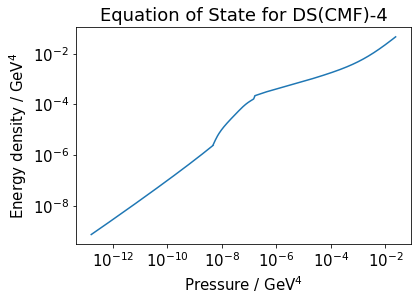

In [5]:
Pa = 1.60218e32

pressure = data['col4']*Pa/nu_eps
energy_density = data['col5']*Pa/nu_eps
plt.loglog(pressure,energy_density)
plt.xlabel('Pressure / GeV$^4$')
plt.ylabel('Energy density / GeV$^4$')
plt.title('Equation of State for DS(CMF)-4')

In [18]:
max(pressure)

0.02368330777942625

In [61]:
# interpolator and lookup for pressure to energy density

f = interpolate.interp1d(pressure,energy_density)

def eps_b(p):
    
    if p<min(pressure):
        return 1e-30
    else:
        return f(p)

In [62]:
## TOV - test for single component baryon:

def test_baryon(r, v):
    m, p = v
    e = eps_b(p)
    return [4*c.pi* r**2 * e, (-nu_G*m*e)/(r**2) * \
                 (1+(p/e)) * (1+((4*c.pi * r**3 * p)/(m))) / (1-((2*nu_G*m)/(r)))]

In [63]:
%%time

def boundary(r, v): return (v[1]-min(pressure))
boundary.terminal = True

R_bm_test = []
M_bm_test = []

for p0 in np.logspace(-5,-2,100):
    sol = integrate.solve_ivp(test_baryon, [1e-10,1e30], [1e-10,p0], dense_output=True, events=boundary,rtol=1e-10)
    R_bm_test.append(sol.t_events[0][0])
    M_bm_test.append(sol.y_events[0][0][0])

CPU times: user 3min 36s, sys: 799 ms, total: 3min 37s
Wall time: 3min 38s


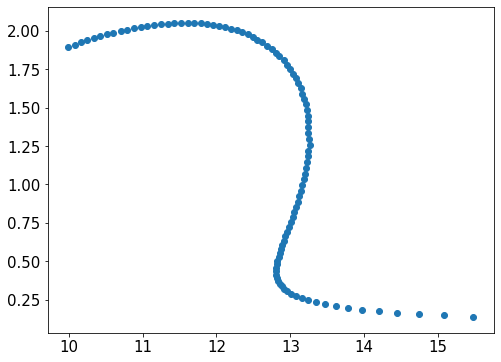

In [64]:
M_sun = 1.98840987e+30
plt.figure(figsize=(8,6))
plt.scatter(np.divide(np.multiply(R_bm_test,nu_length),1e3),np.divide(np.multiply(M_bm_test,nu_mass),M_sun))

# (2) DM EOS:

In [8]:
mx = 100
y_coup = 1e3

eps_dm = lambda x: mx**4 * (((2*x**3+x)*np.sqrt(1+x**2)-np.arcsinh(x)) / (8* c.pi**2) \
                            + (y_coup**2 * x**6)/(9* c.pi**4) )

p_dm = lambda x: mx**4 * (((2*x**3-3*x)*np.sqrt(1+x**2)+3*np.arcsinh(x)) / (24* c.pi**2) \
                            + (y_coup**2 * x**6)/(9* c.pi**4) )

Text(0, 0.5, 'Energy density / GeV$^4$')

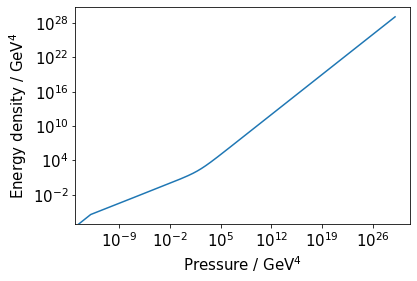

In [9]:
x_space = np.linspace(0,1000,10000001)
p_space = p_dm(x_space)     # y = 1000, m_DM = 100 GeV
e_space = eps_dm(x_space)

plt.loglog(p_space,e_space)
plt.xlabel('Pressure / GeV$^4$')
plt.ylabel('Energy density / GeV$^4$')

In [10]:
## TOV - test for single component dm:

f = interpolate.interp1d(p_space,e_space)

def p_to_e(p):
    
    if p<0:
        return 1e-40
    else:
        return f(p)

def test_dm(r, v):
    m, p = v
    e = p_to_e(p)
    return [4*c.pi* r**2 * e, (-nu_G*m*e)/(r**2) * \
                 (1+(p/e)) * (1+((4*c.pi * r**3 * p)/(m))) / (1-((2*nu_G*m)/(r)))]

In [ ]:
%%time

def boundary(r, v): return (v[1])
boundary.terminal = True

R_dm_test = []
M_dm_test = []

for p0 in np.logspace(-5,10,500):
    sol = integrate.solve_ivp(test_dm, [1e-10,1e80], [1e-10,p0], dense_output=True, events=boundary,rtol=1e-8)
    R_dm_test.append(sol.t_events[0][0])
    M_dm_test.append(sol.y_events[0][0][0])


In [ ]:
plt.plot(np.divide(np.multiply(R_dm_test,nu_length),1e3),np.divide(np.multiply(M_dm_test,nu_mass),M_sun))
plt.xlim(0,0.35)
plt.ylim(0,0.03)
plt.title('Mass-Radius Relation for Dark Star')
plt.xlabel('Radius / km')
plt.ylabel('Mass / $M_\odot$')

In [ ]:
r = np.linspace(1e-10,1e18,500)
y = sol.sol(r)
plt.semilogy(r, y.T[:,1])
print(sol.t_events,sol.y_events)

## 2-component TOV Equation: 

### $$\frac{dp_i}{dr}=-\frac{Gm(r)}{r^2}\bigg[p_i(r)+\epsilon_i(r)\bigg]\bigg[1+\frac{4\pi r^3p(r)}{m(r)}\bigg]\bigg[1-\frac{2Gm(r)}{r}\bigg]^{-1} $$

## Mass Equation: 

### $$\frac{dm}{dr}=4\pi r^2 \epsilon(r)$$

In [65]:
# define neutron star differential equations
# 1: baryonic matter; 2: dark matter

def EOS(r, v):
    m1, m2, p1, p2 = v
    e1 = eps_b(p1)
    e2 = p_to_e(p2)
    return [4*c.pi* r**2 * e1, 4*c.pi* r**2 * e2, \
            (-nu_G*(m1+m2))/(r**2) * (p1+e1) * (1+((4*c.pi * r**3 * (p1+p2))/(m1+m2))) / (1-((2*nu_G*(m1+m2))/r)), \
            (-nu_G*(m1+m2))/(r**2) * (p2+e2) * (1+((4*c.pi * r**3 * (p1+p2))/(m1+m2))) / (1-((2*nu_G*(m1+m2))/r))  ]

In [71]:
%%time

def boundary_bm(r, v): return (v[2]-min(pressure))
def boundary_dm(r, v): return (v[3])
def boundary(r, v): return (v[2]-min(pressure) and v[3])

#boundary.terminal = True



R_bm = []
M_bm = []
R_dm = []
M_dm = []

#for pd in np.logspace(-2,2,4):
for p0 in np.logspace(-3,-2,100):
    sol = integrate.solve_ivp(EOS, [1e-10,1e30], [1e-10,1e-10,p0,1e-1], dense_output=True, \
                              events=(boundary_bm,boundary_dm),rtol=1e-8)
    R_bm.append(sol.t_events[0][0])
    M_bm.append(sol.y_events[0][0][0])
    R_dm.append(sol.t_events[1][0])
    M_dm.append(sol.y_events[1][0][0])



ValueError: A value in x_new is above the interpolation range.

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(np.divide(np.multiply(R_bm,nu_length),1e3),np.divide(np.multiply(M_bm,nu_mass),M_sun),s=10)
plt.title('Mass-Radius Relation with Dark Matter')
plt.axhline(2,c='grey',ls='--')

[array([1.07333712e+18]), array([1.07333714e+18])] [array([[4.97998772e+53, 4.97998772e+53, 1.61386611e-13, 1.61384029e-13]]), array([[ 4.97998772e+53,  4.97998772e+53,  2.58115424e-18,
        -8.66885282e-22]])]


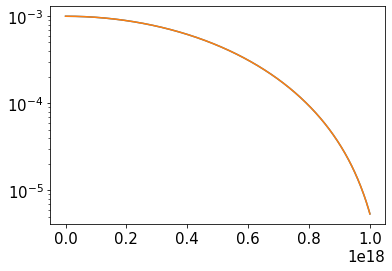

In [37]:
r=np.linspace(1e-10,1e18,500)
y = sol.sol(r)
plt.semilogy(r, y.T[:,2])
plt.semilogy(r, y.T[:,3])
print(sol.t_events,sol.y_events)

In [ ]:
np.shape(R_dm)

In [ ]:
M_plot=np.divide(np.multiply(M_bm,nu_mass),M_sun)
plt.figure(figsize=(8,6))
plt.plot(np.multiply(np.logspace(-5,3,50),nu_eps/nuc),M_plot[:50],label='$p_{0,dm}=1\ GeV^4$')
plt.plot(np.multiply(np.logspace(-5,3,50),nu_eps/nuc),M_plot[50:100],label='$p_{0,dm}=10\ GeV^4$')
#plt.scatter(np.multiply(np.logspace(-5,3,50),nu_eps/nuc),M_plot[100:150],s=20)
#plt.scatter(np.multiply(np.logspace(-5,3,50),nu_eps/nuc),M_plot[150:200],s=20)
#plt.scatter(np.multiply(np.logspace(-5,3,50),nu_eps/nuc),M_plot[200:250],s=20)
#plt.scatter(np.multiply(np.logspace(-5,3,50),nu_eps/nuc),M_plot[250:300],s=20)
plt.xlim(-250,6000)
plt.xlabel('Baryonic Central Pressure (MeV / fm$^3$)')
plt.ylabel('Neutron Star Mass / $M_\odot$')
plt.legend()
#plt.grid()

#plt.title()

In [ ]:
R_plot=np.divide(np.multiply(R_bm,nu_length),1e3)
plt.figure(figsize=(8,7))
plt.plot(np.multiply(np.logspace(-5,3,50),nu_eps/nuc),R_plot[:50],label='$p_{0,dm}=1\ GeV^4$')
plt.plot(np.multiply(np.logspace(-5,3,50),nu_eps/nuc),R_plot[50:100],label='$p_{0,dm}=10\ GeV^4$')
plt.xlim(-250,6e3)
plt.xlabel('Baryonic Central Pressure (MeV / fm$^3$)')
plt.ylabel('Neutron Star Radius (km)')
plt.legend()
#plt.grid()

In [ ]:
DM_plot=np.divide(np.multiply(R_dm,nu_length),1e3)
plt.figure(figsize=(8,6))
plt.plot(np.multiply(np.logspace(-5,3,50),nu_eps/nuc),DM_plot[:50],label='$p_{0,dm}=1\ GeV^4$')
plt.plot(np.multiply(np.logspace(-5,3,50),nu_eps/nuc),DM_plot[50:100],label='$p_{0,dm}=10\ GeV^4$')
#plt.xlim(-500,6e3)
#plt.ylim(top=12)
plt.xlabel('Baryonic Central Pressure (MeV / fm$^3$)')
plt.ylabel('Neutron Star Radius (km)')
plt.legend()
plt.grid()

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(np.divide(np.multiply(R_bm,nu_length),1e3),np.divide(np.multiply(M_bm,nu_mass),M_sun),s=10)
plt.title('Mass-Radius Relation with Dark Matter')
plt.axhline(2,c='grey',ls='--')

In [ ]:
plt.scatter(np.divide(np.multiply(R_dm,nu_length),1e3),np.divide(np.multiply(M_dm,nu_mass),M_sun))

In [ ]:
sol.y_events

In [ ]:
sol.t_events

In [ ]:


sol = integrate.solve_ivp(EOS, [1e-10,1e30], [1e-10,1e-10,1e-1,2], dense_output=True, \
                              events=(boundary_bm,boundary_dm),rtol=1e-8)


r = np.linspace(1e-10,1e19,10000)
y = sol.sol(r)
plt.figure(figsize=(10,8))
plt.semilogy(np.multiply(r,nu_length/1e3), np.multiply(y.T[:,2],nu_eps/nuc),label='Baryonic Matter')
plt.semilogy(np.multiply(r,nu_length/1e3), np.multiply(y.T[:,3],nu_eps/nuc),label='Dark Matter')
plt.legend()
plt.ylabel('Pressure (MeV / fm$^3$)')
plt.xlabel('Radius (km)')
plt.title('$p_{0,bm}=10^{-1} GeV^4, p_{0,dm}=2 GeV^4$, $y =10^4$, $m_X=10^2$ GeV')
#plt.grid()

In [ ]:
tet=np.logspace(0,4,5)
tet

In [ ]:
tet[0:5]

In [ ]:
nuc=1.60218e32

In [ ]:
1e5*nuc/nu_eps

In [ ]:
sol = integrate.solve_ivp(EOS, [1e-10,1e30], [1e-10,1e-10,1e-2,1e-3], dense_output=True, \
                              events=(boundary_bm,boundary_dm),rtol=1e-8)